## **Computer vision project: Deggendorf Waste Sorting Assistant**

### **Overview**
The Deggendorf Waste Sorting Assistant is a Computer Vision-based tool designed to help residents and international students correctly identify waste bins. The project leverages image classification to determine the category of a given waste bin based on its visual characteristics. Users can take a picture of an unlabeled bin, and the model will classify it while providing information on the appropriate waste materials for disposal.

### **Project Goals**
- Develop an image classification model capable of identifying waste bins in Deggendorf.
- Provide users with clear guidance on proper waste disposal based on bin classification.
- Document all processes in a Jupyter Notebook, covering dataset creation, model training, evaluation, and deployment.


### 1. Mount Google Drive & Interactive Labeling Utility

This section sets up everything you need to label images **in-Colab**:

1. Installs required packages  
2. Mounts your Drive  
3. Enables Colab’s custom widget manager for `ipywidgets`  
4. Defines constants, logging, and a CSV to track labels  
5. Provides an interactive widget UI to:
   - Scan `/MyDrive/cv_garbage` for unlabeled images  
   - Display one image at a time  
   - Pick a label from a fixed list  
   - Copy the image into `/MyDrive/cv_garbage/labled` with a standardized name  
   - Record `original_filename`, `new_filename`, `label`, and `timestamp` in `labels.csv`  

---

In [1]:
# 1. Mount Google Drive & Interactive Labeling Utility
# ----------------------------------------------------
import importlib, subprocess, sys, logging
from pathlib import Path
from datetime import datetime, timezone
import shutil, uuid, io, pandas as pd
from PIL import Image as PILImage
import ipywidgets as w
from IPython.display import display
from google.colab import drive, output

In [2]:
# 1.0 · Install / upgrade exact versions (idempotent once per runtime)
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s [%(levelname)s] %(message)s",
                    force=True)
def _ensure(pkg: str):
    mod = pkg.split("==")[0].split(">=")[0]
    try:
        importlib.import_module(mod)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install",
                               "--quiet", pkg])

for spec in (
    "ipywidgets>=8,<9",     # Colab → 8.x
    "pandas>=2.2,<3",
    "pillow>=10,<11",
    "matplotlib>=3.8,<4",
    "scikit-learn>=1.4,<2",
    "tensorflow~=2.16",
):
    _ensure(spec)

In [3]:
# 1.1 · Mount Drive & enable widgets
drive.mount("/content/drive", force_remount=False)
output.enable_custom_widget_manager()

Mounted at /content/drive


In [4]:
# 1.2 · Paths, labels
BASE_DIR    = Path("/content/drive/MyDrive/cv_garbage")
LABELED_DIR = BASE_DIR / "labeled"
CSV_PATH    = LABELED_DIR / "labels.csv"
LABELS      = ["Restmüll", "Biomüll", "Papier", "Gelber Sack", "Glas"]

LABELED_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
# 1.3 · ColabLabeler (unchanged API, safer internals)
class ColabLabeler:
    EXT = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp"}

    def __init__(self, src_dir: Path, dst_dir: Path,
                 csv_path: Path, labels: list[str]) -> None:
        self.src, self.dst, self.csv = src_dir, dst_dir, csv_path
        self.labels = labels
        self._df    = self._load_or_init()
        self._todo  = self._find_unlabeled()
        self._idx   = 0

        # widgets
        self._w_img  = w.Image(layout=w.Layout(max_width="640px",
                                               border="1px solid #bbb"))
        self._w_lbl  = w.ToggleButtons(options=self.labels,
                                       description="Label:")
        self._w_next = w.Button(description="Save & Next ▶️",
                                button_style="success")
        self._w_skip = w.Button(description="Skip ⏭️")
        self._w_msg  = w.HTML()

        self._w_next.on_click(self._on_save)
        self._w_skip.on_click(self._on_skip)

        self.ui = w.VBox([self._w_img, self._w_lbl,
                          w.HBox([self._w_next, self._w_skip]),
                          self._w_msg])

    # ── persistence ────────────────────────────────────────────────
    def _load_or_init(self):
        if self.csv.exists():
            return pd.read_csv(self.csv)
        return pd.DataFrame(columns=["original_filename",
                                     "new_filename",
                                     "label",
                                     "timestamp"])

    def _find_unlabeled(self):
        imgs = sorted(p.name for p in self.src.iterdir()
                      if p.suffix.lower() in self.EXT)
        done = set(self._df["original_filename"])
        return [f for f in imgs if f not in done]

    def _write(self, orig, new, label):
        ts = datetime.now(timezone.utc).isoformat(timespec="seconds")
        self._df.loc[len(self._df)] = [orig, new, label, ts]
        tmp = self.csv.with_suffix(".tmp")
        self._df.to_csv(tmp, index=False)
        tmp.replace(self.csv)

    # ── helpers ────────────────────────────────────────────────────
    def _flash(self, msg, level="info"):
        color = dict(info="#444", success="green",
                     warn="orange", error="red").get(level, "#444")
        self._w_msg.value = f"<span style='color:{color}'>{msg}</span>"

    def _render(self):
        if self._idx >= len(self._todo):
            self._w_img.value = b""
            self._flash("🎉 All images processed.", "success")
            self._w_next.disabled = self._w_skip.disabled = True
            return
        fname = self._todo[self._idx]
        try:
            with PILImage.open(self.src / fname) as im:
                im.thumbnail((640, 480))
                buf = io.BytesIO()
                im.save(buf, format="PNG")
            self._w_img.value  = buf.getvalue()
            self._w_img.format = "png"
            self._flash(f"{self._idx+1}/{len(self._todo)} · {fname}")
        except Exception as exc:
            self._flash(f"❌ {exc}", "error")

    # ── callbacks ──────────────────────────────────────────────────
    def _on_save(self, _btn):
        orig  = self._todo[self._idx]
        label = self._w_lbl.value.replace(" ", "_")
        new   = f"{label}_{uuid.uuid4().hex[:8]}{Path(orig).suffix}"
        try:
            shutil.copy2(self.src / orig, self.dst / new)
            self._write(orig, new, label)
            self._flash(f"✔️ Saved {new}", "success")
        except Exception as exc:
            self._flash(f"❌ {exc}", "error")
            return
        self._idx += 1
        self._render()

    def _on_skip(self, _btn):
        self._idx += 1
        self._flash("⏭️ Skipped.", "warn")
        self._render()

    # ── public ─────────────────────────────────────────────────────
    def start(self):
        if not self._todo:
            self._flash(f"No unlabeled images in {self.src}", "warn")
        else:
            self._render()
        display(self.ui)

# 1.4 · Launch label-widget
labeler = ColabLabeler(BASE_DIR, LABELED_DIR, CSV_PATH, LABELS)
labeler.start()

### 2. Import Required Libraries for the Rest of the Project

In [13]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

#### 2.1 Visualise the Labeled Dataset

Total labeled images: 73


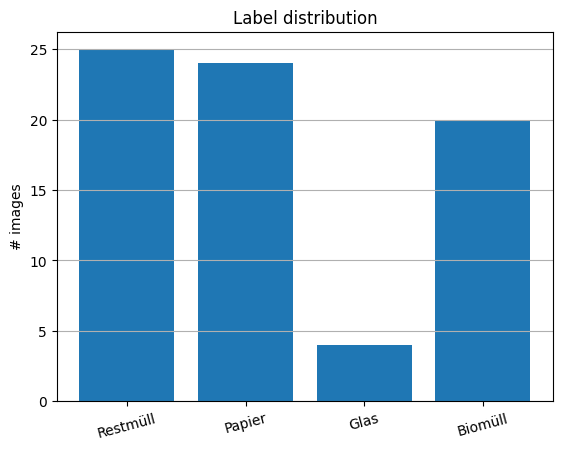

⚠️  Consider ≥30 images per class for a stable baseline.


In [14]:
from collections import Counter
if CSV_PATH.exists():
    df = pd.read_csv(CSV_PATH)
    print(f"Total labeled images: {len(df)}")
    cnt = Counter(df["label"])
    plt.figure()
    plt.title("Label distribution")
    plt.bar(cnt.keys(), cnt.values())
    plt.xticks(rotation=15)
    plt.ylabel("# images")
    plt.grid(axis="y")
    plt.show()

    min_cls = min(cnt.values()) if cnt else 0
    if min_cls < 30:
        print("⚠️  Consider ≥30 images per class for a stable baseline.")
else:
    print("Run the labeler first → no CSV found yet.")

### 3. Dataset Creation

In [10]:
# TODO: code for splitting data, creating train/val folders, etc. …

In [ ]:
from sklearn.model_selection import train_test_split

#### 3.1 Pre-Training Goals

| Metric                     | Target | Why it matters                           |
|----------------------------|--------|------------------------------------------|
| Images *per class* (min)   | ≥ 50   | Small transfer-learning baseline         |
| Train / Val / Test split   | 70/15/15 % | Keeps unseen data for demo           |
| Baseline accuracy          | ≥ 55 % | Must beat majority-class trivial model   |
| Final val. accuracy        | ≥ 85 % | “good enough” for daily use              |
| Per-class F1               | ≥ 0.80 | No class left behind                     |

#### 3.2 Next-Steps Checklist

- [ ] **Finish labeling** the remaining 66 images (tonight)
- [ ] Run **Section 2.1** and paste the bar-plot into slides
- [ ] Ensure each class reaches ≥50 images (photograph extra bins if needed)
- [ ] Implement Section 3 split script and push data to train/val/test dirs
- [ ] Bring the notebook, `labels.csv`, and slides to tomorrow’s meeting

### 4. Model Training

In [11]:
# TODO: code for defining and training your CNN …

### 5. Evaluation & Deployment

In [12]:
# TODO: code for evaluating accuracy, exporting a TensorFlow Lite model, etc. …